# Project 4

## Retrieve data Using PySpark

In [5]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install keras-tuner


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.5 MB/s eta 0:00:00


In [6]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType
from pyspark import SparkFiles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
import keras_tuner as kt

# Set up SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Read in data
filepath = "/content/drive/MyDrive/Project4/Project-4/Resources/winequality-red.csv"

print(filepath)

spark.sparkContext.addFile(filepath)
df = spark.read.csv(SparkFiles.get("winequality-red.csv"), header=True, inferSchema=True, quote="\"", escape="\"")

# Show DataFrame
df.show()

/content/drive/MyDrive/Project4/Project-4/Resources/winequality-red.csv
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|

In [9]:
#Create a temporary view.
df.createOrReplaceTempView('wine_data')

In [12]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark.sql("SELECT * FROM wine_data").toPandas()

In [13]:
# Explore and clean data
max_quality = pandas_df["quality"].max()
min_quality = pandas_df["quality"].min()
data_info = pandas_df.info()
data_description = pandas_df.describe()
quality_counts = pandas_df["quality"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


In [14]:
pandas_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Check data and clean if required

In [ ]:
pandas_df["quality"].max()

8

In [ ]:
pandas_df["quality"].min()

3

In [ ]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


In [ ]:
pandas_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
pandas_df["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [ ]:
pandas_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Everything looks good and clean. Let's proceed

## Define Target based on quality rating: 7 or above =  good. Otherwise bad.

In [15]:
# Define target based on quality rating: 7 or above = good, otherwise bad
pandas_df['target'] = (pandas_df['quality'] >= 7).astype(int)
target_names = ['bad quality', 'good quality']


pandas_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [ ]:
pandas_df['target'].unique()

array(['0', '1'], dtype=object)

In [16]:
# Extract features and target
X = pandas_df.iloc[:, :11]
y = pandas_df['target']

In [17]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [18]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [19]:
#features
print(X)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

In [20]:
#target
y.value_counts()


0    1382
1     217
Name: target, dtype: int64

## Preprocessing: Split test and training data & Standard Scaler

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [22]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [23]:
# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

In [24]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Run Models

## Logistic Regression - `solver='lbfgs'`

In [25]:
# instantiate the Logistic Regression model as classifier

classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier

LogisticRegression(max_iter=200, random_state=1)

In [26]:
# Fit model using scaled training data

lr_model = classifier.fit(X_train_scaled, y_train)
lr_model


LogisticRegression(max_iter=200, random_state=1)

## Create predictded values for test and train

In [27]:
#Generate training predictions
# training_predictions = lr_model.predict(X_train.values)

#Generate testing predictions
testing_predictions = classifier.predict(X_test.values)

## Confusion Matrix for testing data

In [28]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[317  38]
 [ 32  13]]


## Classification report for testing

In [29]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions, target_names=target_names)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 bad quality       0.91      0.89      0.90       355
good quality       0.25      0.29      0.27        45

    accuracy                           0.82       400
   macro avg       0.58      0.59      0.59       400
weighted avg       0.83      0.82      0.83       400



## Logistic Regression - `solver='liblinear'`

In [30]:
# instantiate the Logistic Regression model as classifier

classifier = LogisticRegression(solver='liblinear',
                                max_iter=200,
                                random_state=1)
classifier

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

In [31]:
# Fit model using scaled training data

lr_model = classifier.fit(X_train_scaled, y_train)
lr_model


LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

## Create predictded values for test and train

In [32]:
#Generate training predictions
# training_predictions = lr_model.predict(X_train.values)

#Generate testing predictions
testing_predictions = classifier.predict(X_test.values)

## Confusion Matrix for testing data

In [33]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[317  38]
 [ 31  14]]


## Classification report for testing

In [34]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions, target_names=target_names)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 bad quality       0.91      0.89      0.90       355
good quality       0.27      0.31      0.29        45

    accuracy                           0.83       400
   macro avg       0.59      0.60      0.60       400
weighted avg       0.84      0.83      0.83       400



## Logistic Regression with `RandomOverSampler` from imblearn

In [35]:
# Import the RandomOverSampler module form imbalanced-learn

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)
# Fit the original training data to the random_oversampler model
X_res, y_res = ros.fit_resample(X_train, y_train)

In [36]:
# Count the distinct values of the resampled labels data
y_res.value_counts()

0    1027
1    1027
Name: target, dtype: int64

## `LogisticRegression` classifier

In [37]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1,
                                               max_iter=1000)

# Fit the model using the resampled training data
lr_model_res = logistic_regression_model.fit(X_res, y_res)

# Make a prediction using the testing data
predictions_res = lr_model_res.predict(X_test)

## Confusion Matrix for testing data

In [38]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, predictions_res)

# Print the confusion matrix for the testing data
print(test_matrix)

[[274  81]
 [  7  38]]


## Classification report for testing

In [39]:
print(classification_report(y_test, predictions_res, target_names=target_names))


              precision    recall  f1-score   support

 bad quality       0.98      0.77      0.86       355
good quality       0.32      0.84      0.46        45

    accuracy                           0.78       400
   macro avg       0.65      0.81      0.66       400
weighted avg       0.90      0.78      0.82       400



## try different models other than Logistic Regression

## random forest

In [40]:
rf_classifier = RandomForestClassifier()
rf_model = rf_classifier.fit(X_train, y_train)
rf_predict= rf_classifier.predict(X_test)

In [41]:
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print(rf_conf_matrix)
print(rf_acc_score*100)

[[345  10]
 [ 23  22]]
91.75


In [42]:
#Generate training predictions
training_predictions = rf_model.predict(X_train)

#Generate testing predictions
testing_predictions = rf_classifier.predict(X_test)

## Confusion Matrix for testing data

In [43]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[345  10]
 [ 23  22]]


## Classification report for testing

In [44]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions, target_names=target_names)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 bad quality       0.94      0.97      0.95       355
good quality       0.69      0.49      0.57        45

    accuracy                           0.92       400
   macro avg       0.81      0.73      0.76       400
weighted avg       0.91      0.92      0.91       400



## SVM classifier

In [45]:

lin_svc_classifier = SVC()
lin_svc_model = lin_svc_classifier.fit(X_train, y_train)
lin_svc_predict = lin_svc_classifier.predict(X_test)

In [46]:
lin_svc_conf_matrix = confusion_matrix(y_test, rf_predict)
lin_svc_acc_score = accuracy_score(y_test, rf_predict)
print(lin_svc_conf_matrix)
print(lin_svc_acc_score*100)

[[345  10]
 [ 23  22]]
91.75


In [47]:
#Generate training predictions
training_predictions = lin_svc_model.predict(X_train)

#Generate testing predictions
testing_predictions = lin_svc_classifier.predict(X_test)

## Confusion Matrix for testing data

In [48]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[355   0]
 [ 44   1]]


## Classification report for testing

In [49]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions, target_names=target_names)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 bad quality       0.89      1.00      0.94       355
good quality       1.00      0.02      0.04        45

    accuracy                           0.89       400
   macro avg       0.94      0.51      0.49       400
weighted avg       0.90      0.89      0.84       400



In [50]:
type(y_train)

pandas.core.series.Series

In [ ]:
type(y_test)

pandas.core.series.Series

In [51]:
# Convert string labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Data visualistations

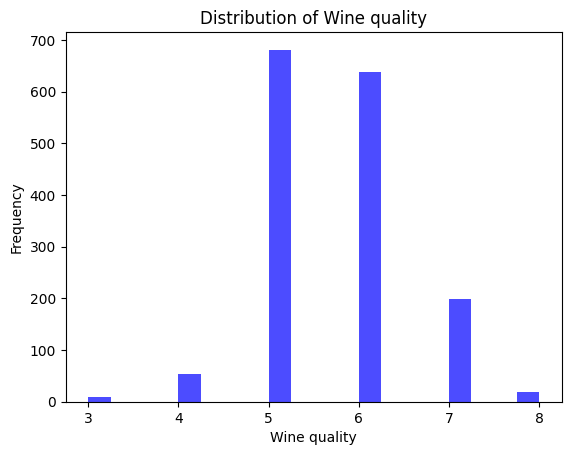

In [52]:
import matplotlib.pyplot as plt

# Example for one feature
plt.hist(pandas_df['quality'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Wine quality')
plt.xlabel('Wine quality')
plt.ylabel('Frequency')
plt.show()


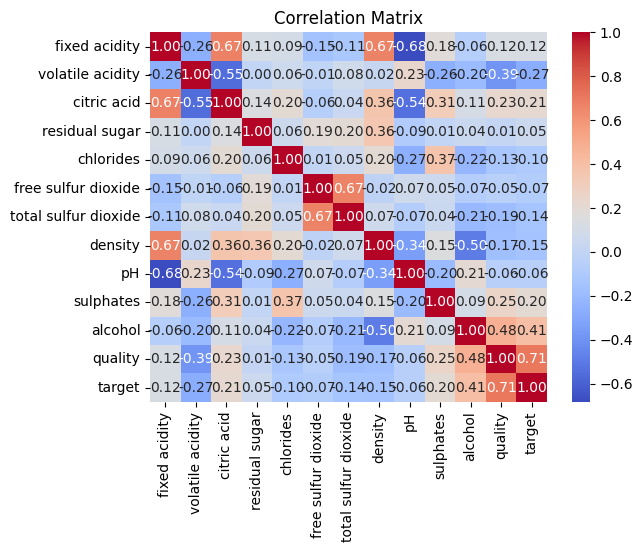

In [53]:
import seaborn as sns

correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


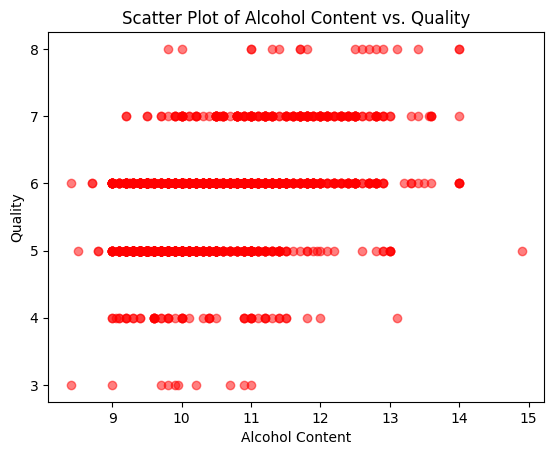

In [54]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(pandas_df['alcohol'], pandas_df['quality'], alpha=0.5,color="red")
plt.title('Scatter Plot of Alcohol Content vs. Quality')
plt.xlabel('Alcohol Content')
plt.ylabel('Quality')
plt.show()


## Nueral Network Deep Learning with Keras Tuner

In [55]:
# Neural Network Deep Learning with Keras Tuner
def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    activation = hp.Choice('activation', ['relu', 'tanh'])
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', min_value=1, max_value=30, step=5),
                                       activation=activation, input_dim=11))

    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=1, max_value=40, step=5),
                                           activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return nn_model

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=40,
    hyperband_iterations=2
)

tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

best_hyper = tuner.get_best_hyperparameters(1)
for param in best_hyper:
    print(param.values)

top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Trial 180 Complete [00h 00m 06s]
val_accuracy: 0.8924999833106995

Best val_accuracy So Far: 0.9125000238418579
Total elapsed time: 00h 08m 44s
{'activation': 'tanh', 'first_units': 26, 'num_layers': 5, 'units_0': 21, 'units_1': 31, 'units_2': 11, 'units_3': 1, 'units_4': 21, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0160'}
{'activation': 'tanh', 'first_units': 16, 'num_layers': 4, 'units_0': 11, 'units_1': 21, 'units_2': 6, 'units_3': 1, 'units_4': 26, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}
{'activation': 'tanh', 'first_units': 21, 'num_layers': 3, 'units_0': 11, 'units_1': 26, 'units_2': 1, 'units_3': 11, 'units_4': 11, 'tuner/epochs': 14, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 26, 'num_layers': 5, 'units_0': 21, 'units_1': 31, 'units_2': 11, 'units_3': 1, 'units_4': 21, 'tuner/epochs': 40,

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=11))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=40,
            step=5),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [ ]:
# Import the kerastuner library

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=40,
    hyperband_iterations=2)




Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 180 Complete [00h 00m 13s]
val_accuracy: 0.8949999809265137

Best val_accuracy So Far: 0.9150000214576721
Total elapsed time: 00h 48m 29s


In [ ]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 26, 'num_layers': 3, 'units_0': 1, 'units_1': 21, 'units_2': 1, 'units_3': 36, 'tuner/epochs': 14, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0036', 'units_4': 6}
{'activation': 'relu', 'first_units': 16, 'num_layers': 1, 'units_0': 21, 'units_1': 1, 'units_2': 1, 'units_3': 6, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0010', 'units_4': 31}
{'activation': 'tanh', 'first_units': 26, 'num_layers': 3, 'units_0': 1, 'units_1': 21, 'units_2': 1, 'units_3': 36, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0004', 'units_4': 6}


In [ ]:
# Get top model hyperparameters and print the values
best_hyper = tuner.get_best_hyperparameters(1)
for param in best_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 26, 'num_layers': 3, 'units_0': 1, 'units_1': 21, 'units_2': 1, 'units_3': 36, 'tuner/epochs': 14, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0036', 'units_4': 6}


In [ ]:
type(best_hyper)
best_hyper[0]['tuner/epochs']

14

In [ ]:
# Evaluate the top 3 model against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

    testing_report = classification_report(y_test, testing_predictions, target_names=target_names)


13/13 - 1s - loss: 0.4646 - accuracy: 0.9150 - 525ms/epoch - 40ms/step
Loss: 0.46463558077812195, Accuracy: 0.9150000214576721


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0 1] and y_pred=['0' '1']. Make sure that the predictions provided by the classifier coincides with the true labels.

## mr GPT

In [ ]:
input_shape = X_train.shape[1]
input_shape

output_units = 2
output_activation = 'sigmoid'

In [ ]:
# Evaluate the model on your test data
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()  # Convert probabilities to 0 or 1
y_true_classes = y_test.values  # Convert pandas Series to NumPy array

# Generate a classification report
print(classification_report(y_true_classes, y_pred_classes))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

# Define the best hyperparameters
best_hyperparameters = {
    'activation': 'relu',
    'first_units': 26,
    'num_layers': 1,
    'units_0': 21,
    'units_1': 31,
    'units_2': 11,
    'units_3': 31,
    'units_4': 6,
    'tuner/epochs': 5,
    'tuner/initial_epoch': 2,
}

# Assuming you have the correct input_shape and output_units
# input_shape = ...  # Replace with your input shape
output_units = 2  # Binary classification, so 2 output units
output_activation = 'sigmoid'  # Binary classification, so 'sigmoid' activation

# Create the model using the best hyperparameters
model = Sequential()
model.add(Dense(units=best_hyper[0]['first_units'], activation=best_hyper[0]['activation'], input_shape=(input_shape,)))

# For binary classification
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for i in range(best_hyper[0]['num_layers']):
    model.add(Dense(units=best_hyper[0][f'units_{i}'], activation=best_hyper[0]['activation']))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with your training data
model.fit(X_train, y_train, epochs=best_hyper[0]['tuner/epochs'], initial_epoch=best_hyper[0]['tuner/initial_epoch'])

# Evaluate the model on your test data
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()  # Convert probabilities to 0 or 1

# Ensure y_test is correctly formatted and has the same number of samples as X_test
y_true_classes = y_test.values.squeeze()  # Squeeze to handle potential extra dimensions

# Generate a classification report
print(classification_report(y_true_classes, y_pred_classes))


Epoch 3/5
38/38 [==============================] - 2s 4ms/step - loss: 1.3810 - accuracy: 0.0000e+00
Epoch 4/5
38/38 [==============================] - 0s 4ms/step - loss: 1.3556 - accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 3ms/step


ValueError: Found input variables with inconsistent numbers of samples: [400, 8400]